# Inverse Problems

## Blur + Noise reconstruction

Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import equinox as eqx
import jax 
import jax.scipy as jsp
import jax.numpy as jnp
import helper as hlp
from tqdm import tqdm
import optax 

%matplotlib inline
%load_ext autoreload
%autoreload 2

Working images 

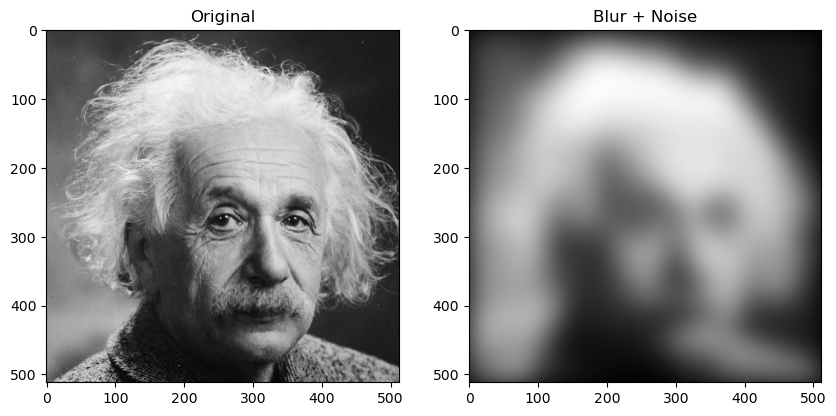

In [3]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)

# blurred and noisy img
gaussian_kernel = hlp.get_2D_Gaussian_kernel(20)
blur_img = jsp.signal.convolve(img,gaussian_kernel, mode='same')
np.random.seed(4)
gaussian_noise = np.random.normal(0, 1, img.shape)
blur_noise_img = blur_img + gaussian_noise
blur_noise_img= np.clip(blur_noise_img, 0,255)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

Reconstruction

In [4]:
# model 
class Model(eqx.Module):
    kernel: jnp.ndarray
    # y: jnp.ndarray


    def __init__(self, kernel):
        self.kernel = kernel
        # self.y = y

    def __call__(self, x):
        Ax = jsp.signal.convolve(x,self.kernel, mode='same')
        return Ax
    

# loss function 
def loss(x, y, A): # not sure if it's better to put the loss inside the "Model" class
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return loss

# optimizer --> Proximal gradient descent
# @jax.jit  # passer loss en parametre fix --> sinon jit fonctionne pas
def optimizer_step(x, y, A, alpha, loss_fn):  # alpha = learning rate
    loss_val, grads_val = jax.value_and_grad(loss_fn)(x, y, A)
    print(grads_val)
    
    # GD update
    x_new = x - alpha * grads_val

    # projection
    # x_new = jnp.clip(x_new, 0, 255)

    return loss_val, x_new





In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.5
n_iter = 200 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss) 
    losses.append(loss_val)

100%|██████████| 200/200 [04:53<00:00,  1.47s/it]


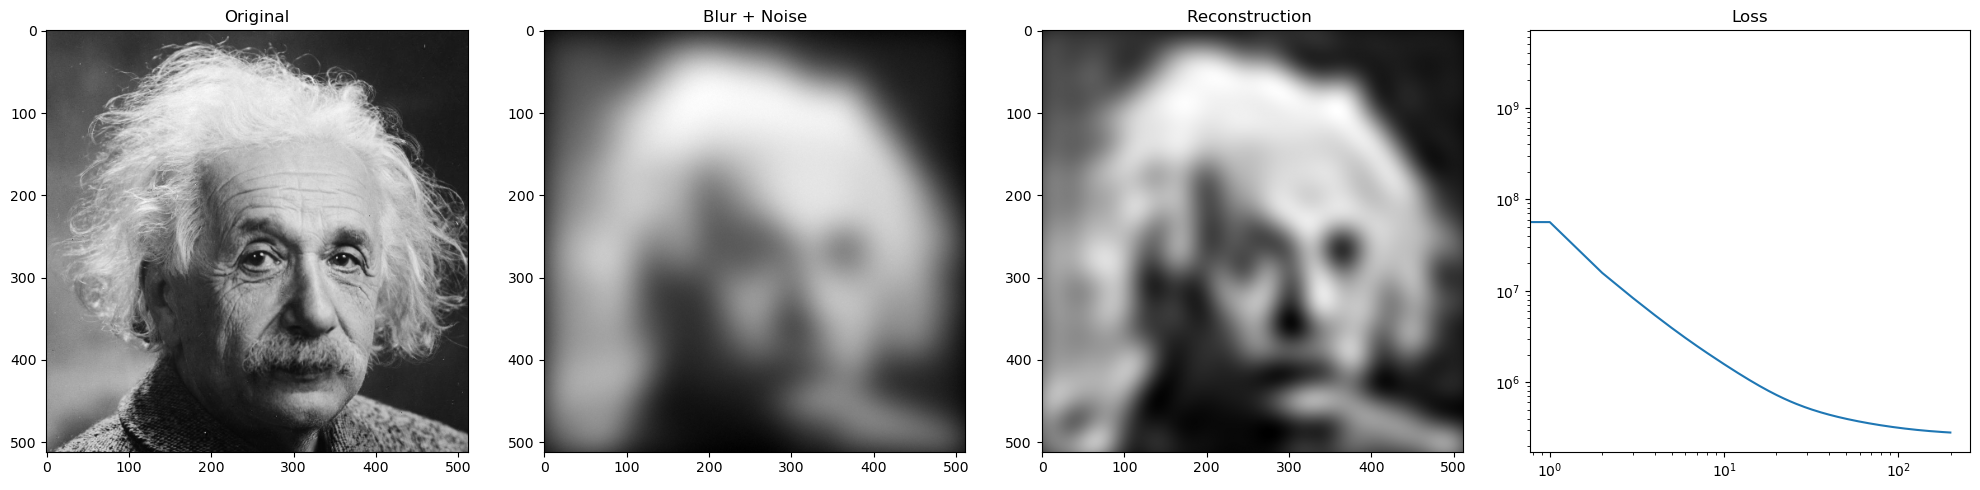

In [57]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

with ADAM optimizer

In [70]:
# optimization parameters
alpha = 7
n_iter = 300


# optimizer --> ADAM
ADAM_optimizer = optax.adam(learning_rate=alpha)

# @jax.jit ###############  checker pq je n'arrive pas 
def adam_optimizer_step(x, opt_state, loss):
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    
    # ADAM update
    updates, opt_state = ADAM_optimizer.update(grads_val, opt_state)
    x = optax.apply_updates(x, updates)

    # projection
    # x_new = jnp.clip(x_new, 0, 255)

    return x, opt_state, loss_val


# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
opt_state = ADAM_optimizer.init(x)

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    x, opt_state, loss_val  = adam_optimizer_step(x, opt_state, loss) 
    losses.append(loss_val)

100%|██████████| 300/300 [08:40<00:00,  1.73s/it]


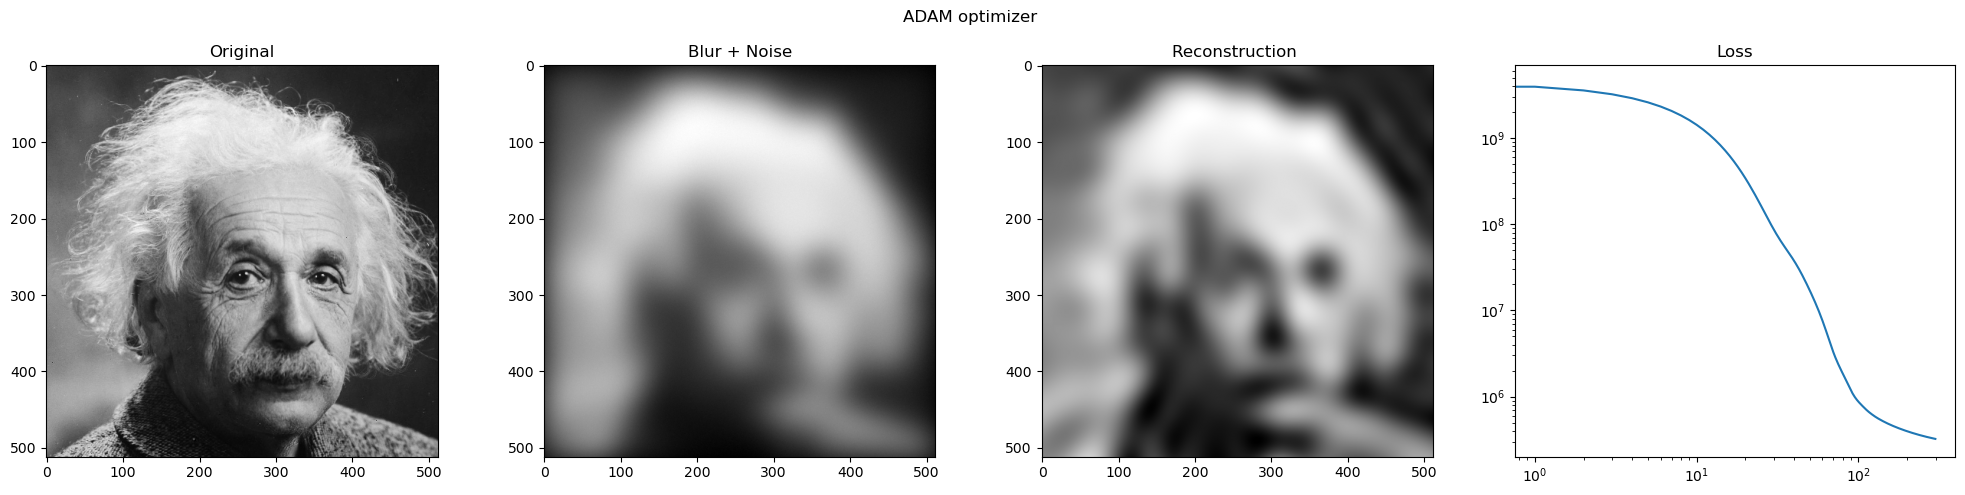

In [71]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('ADAM optimizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

### With regulizer 

- L2: \norm{.}{2}^{2}

In [ ]:
# loss function 
def loss_rL2(x, y, A): # not sure if it's better to put the loss inside the "Model" class
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2 + jnp.linalg.norm(x)**2
    return loss

# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.5
n_iter = 10 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    # print(x)
    loss_val, x = optimizer_step(x, y, A, alpha, loss_rL2) 
    losses.append(loss_val)

100%|██████████| 10/10 [00:00<00:00, 468.50it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

In [24]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
loss

<function __main__.loss(x, y, A)>

In [25]:
x

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
x

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
def test_loss(x):
    test= jnp.linalg.norm(x)**2
    return test

In [37]:
test_loss(x+1)


Array(262144., dtype=float32)

In [42]:
jax.grad(test_loss)(x+1)

Array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

In [5]:
losses

[Array(4.344606e+09, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32)]

In [ ]:
loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2 + 0.1*jnp.linalg.norm(x)**2
loss(4.344606e+09

Array(4.7384685e+08, dtype=float32)

In [114]:
0.1*jnp.linalg.norm(x)**2

Array(4.7227197e+08, dtype=float32)

In [113]:
loss + 0.1*jnp.linalg.norm(x)**2

Array(4.7384685e+08, dtype=float32)

In [111]:
loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2 
loss

Array(1574871.2, dtype=float32)

C:\Users\ismae\AppData\Local\Temp\ipykernel_12928\610348142.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


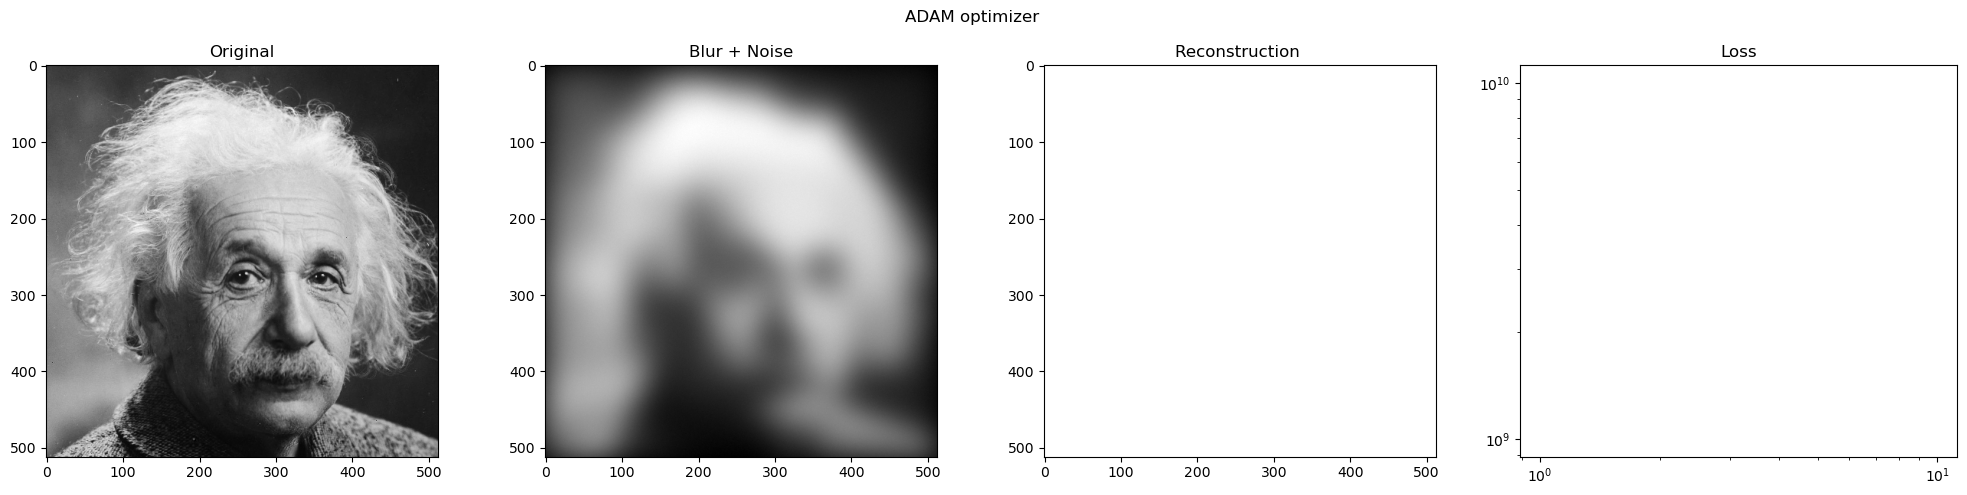

In [76]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('ADAM optimizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()